# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Скачайте его кстати, 

```(bash)
mkdir cifar10
curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xvzf cifar-10-python.tar.gz -C cifar10
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [30]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train,X_test, y_test = load_CIFAR10(cifar10_dir)





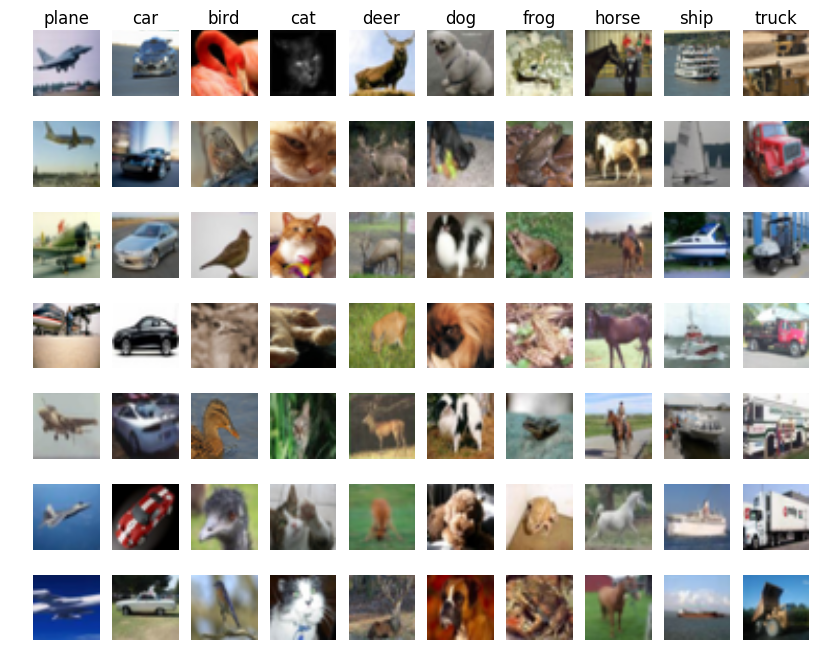

In [31]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').reshape(32, 32, 3))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [32]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

Так задаётся архитектура нейронки

In [33]:
input_layer = lasagne.layers.InputLayer(shape=(None,3, 32, 32), input_var=input_X)
nnet1 = lasagne.layers.Conv2DLayer(input_layer,num_filters=32,filter_size=3,nonlinearity=rectify)
nnet2 = lasagne.layers.Conv2DLayer(nnet1,num_filters=32,filter_size=3,nonlinearity=rectify)
nnet3=lasagne.layers.Pool2DLayer(nnet2,pool_size=3)
nnet4=lasagne.layers.DropoutLayer(nnet3,p=0.25)
nnet5=lasagne.layers.Conv2DLayer(nnet4,num_filters=64,filter_size=3,nonlinearity=rectify)
nnet6=lasagne.layers.Conv2DLayer(nnet5,num_filters=64,filter_size=3,nonlinearity=rectify)
nnet7=lasagne.layers.Pool2DLayer(nnet6,pool_size=3)
nnet8=lasagne.layers.DropoutLayer(nnet7,p=0.25)
nnet9=lasagne.layers.FlattenLayer(nnet8)
nnet10=lasagne.layers.DenseLayer(nnet9,num_units = 512, nonlinearity=rectify)
nnet11=lasagne.layers.DropoutLayer(nnet10,p=0.5)
# Для вдохновления 
# - http://torch.ch/blog/2015/07/30/cifar.html
# - http://www.robots.ox.ac.uk/~vgg/research/very_deep/
# - https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf
dense_output = lasagne.layers.DenseLayer(nnet11,num_units = 10, nonlinearity=softmax)

In [34]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [35]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print all_weights

[W, b, W, b, W, b, W, b, W, b, W, b]


### дальше вы могли бы просто
* задать функцию ошибки вручную
* посчитать градиент ошибки по all_weights
* написать updates
* но это долго, а простой шаг по градиенту - не самый лучший смособ оптимизировать веса

Вместо этого, опять используем lasagne

In [36]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()
updates_sgd = lasagne.updates.rmsprop(loss, all_weights,learning_rate=0.01)

In [37]:
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates_sgd)
accuracy_fun = theano.function([input_X,target_y],accuracy)

### Вот и всё, пошли её учить

In [38]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [39]:
import time

num_epochs = 10 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

TypeError: Bad input argument to theano function with name "<ipython-input-37-c125fe61b603>:1" at index 1 (0-based).  
Backtrace when that variable is created:

  File "/Users/MarkPotanin/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/MarkPotanin/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/MarkPotanin/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/MarkPotanin/anaconda/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/MarkPotanin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/MarkPotanin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/MarkPotanin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-d49cf17c66cd>", line 6, in <module>
    target_y = T.vector("target Y integer",dtype='int32')
TensorType(int32, vector) cannot store a value of dtype int64 without risking loss of precision. If you do not mind this loss, you can: 1) explicitly cast your data to int32, or 2) set "allow_input_downcast=True" when calling "function". Value: "array([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6,
       6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1,
       1, 2, 2, 0])"

In [40]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

TypeError: Bad input argument to theano function with name "<ipython-input-37-c125fe61b603>:2" at index 1 (0-based).  
Backtrace when that variable is created:

  File "/Users/MarkPotanin/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/MarkPotanin/anaconda/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/MarkPotanin/anaconda/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/MarkPotanin/anaconda/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/MarkPotanin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/MarkPotanin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/MarkPotanin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-d49cf17c66cd>", line 6, in <module>
    target_y = T.vector("target Y integer",dtype='int32')
TensorType(int32, vector) cannot store a value of dtype int64 without risking loss of precision. If you do not mind this loss, you can: 1) explicitly cast your data to int32, or 2) set "allow_input_downcast=True" when calling "function". Value: "array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4,
       9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9,
       3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3,
       7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3,
       8, 6, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1,
       3, 0, 4, 2, 7, 8, 3, 1, 2, 8, 0, 8, 3, 5, 2, 4, 1, 8, 9, 1, 2, 9, 7,
       2, 9, 6, 5, 6, 3, 8, 7, 6, 2, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 5, 4, 2,
       1, 6, 6, 8, 4, 8, 4, 5, 0, 9, 9, 9, 8, 9, 9, 3, 7, 5, 0, 0, 5, 2, 2,
       3, 8, 6, 3, 4, 0, 5, 8, 0, 1, 7, 2, 8, 8, 7, 8, 5, 1, 8, 7, 1, 3, 0,
       5, 7, 9, 7, 4, 5, 9, 8, 0, 7, 9, 8, 2, 7, 6, 9, 4, 3, 9, 6, 4, 7, 6,
       5, 1, 5, 8, 8, 0, 4, 0, 5, 5, 1, 1, 8, 9, 0, 3, 1, 9, 2, 2, 5, 3, 9,
       9, 4, 0, 3, 0, 0, 9, 8, 1, 5, 7, 0, 8, 2, 4, 7, 0, 2, 3, 6, 3, 8, 5,
       0, 3, 4, 3, 9, 0, 6, 1, 0, 9, 1, 0, 7, 9, 1, 2, 6, 9, 3, 4, 6, 0, 0,
       6, 6, 6, 3, 2, 6, 1, 8, 2, 1, 6, 8, 6, 8, 0, 4, 0, 7, 7, 5, 5, 3, 5,
       2, 3, 4, 1, 7, 5, 4, 6, 1, 9, 3, 6, 6, 9, 3, 8, 0, 7, 2, 6, 2, 5, 8,
       5, 4, 6, 8, 9, 9, 1, 0, 2, 2, 7, 3, 2, 8, 0, 9, 5, 8, 1, 9, 4, 1, 3,
       8, 1, 4, 7, 9, 4, 2, 7, 0, 7, 0, 6, 6, 9, 0, 9, 2, 8, 7, 2, 2, 5, 1,
       2, 6, 2, 9, 6, 2, 3, 0, 3, 9, 8, 7, 8, 8, 4, 0, 1, 8, 2, 7, 9, 3, 6,
       1, 9, 0, 7, 3, 7, 4, 5, 0, 0, 2, 9, 3, 4, 0, 6, 2, 5, 3, 7, 3, 7, 2,
       5, 3, 1, 1, 4, 9, 9, 5, 7, 5, 0, 2, 2, 2, 9, 7, 3, 9, 4, 3, 5, 4, 6,
       5, 6, 1, 4, 3, 4, 4, 3, 7, 8, 3, 7, 8, 0, 5, 7, 6, 0, 5, 4, 8, 6, 8,
       5, 5, 9, 9, 9, 5, 0, 1, 0, 8, 1, 1, 8, 0, 2, 2, 0])"

## Заполните форму

https://goo.gl/forms/FsANPB1jSqmX1JBJ3